In [1]:
import pandas as pd 
import numpy as np 
import missingno as msno
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import shap
import math

In [2]:
df = pd.read_csv(r'C:\Users\LENOVO\Downloads\archive\Subscription_Dataset.csv')
df.head()

,AccountAge,MonthlyCharges,TotalCharges,SubscriptionType,PaymentMethod,PaperlessBilling,ContentType,MultiDeviceAccess,DeviceRegistered,ViewingHoursPerWeek,...,ContentDownloadsPerMonth,GenrePreference,UserRating,SupportTicketsPerMonth,Gender,WatchlistSize,ParentalControl,SubtitlesEnabled,CustomerID,Churn
0,42,11.321950,475.521914,Basic,Electronic check,Yes,Movies,Yes,Tablet,0.386852,...,25,Comedy,3.489465,7,Female,15,No,No,LOHRYYC9E8,0
1,95,12.810915,1217.036887,Standard,Electronic check,Yes,TV Shows,No,Mobile,37.123000,...,21,Comedy,2.251860,3,Male,8,No,NaN,RIH7RFEZCS,0
2,6,NaN,91.583304,Standard,Credit card,Yes,TV Shows,No,Tablet,30.716944,...,29,Fantasy,NaN,4,Male,14,No,Yes,JB5J8X2UY1,1
3,54,17.917819,967.562224,Basic,NaN,Yes,Movies,No,Mobile,2.495373,...,45,Drama,1.275004,3,Male,12,No,NaN,Z4GZJIB90P,0
4,27,NaN,339.057244,Basic,Mailed check,No,TV Shows,No,Mobile,39.936910,...,44,Comedy,3.236230,4,Female,18,No,NaN,B3BDJTW0L9,0


## 1. EDA - Limpieza y transformación de los datos

In [3]:
#Revisión de la estructura del DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 963 entries, 0 to 962
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   AccountAge                963 non-null    int64  
 1   MonthlyCharges            759 non-null    float64
 2   TotalCharges              777 non-null    float64
 3   SubscriptionType          913 non-null    object 
 4   PaymentMethod             740 non-null    object 
 5   PaperlessBilling          963 non-null    object 
 6   ContentType               963 non-null    object 
 7   MultiDeviceAccess         963 non-null    object 
 8   DeviceRegistered          887 non-null    object 
 9   ViewingHoursPerWeek       963 non-null    float64
 10  AverageViewingDuration    963 non-null    float64
 11  ContentDownloadsPerMonth  963 non-null    int64  
 12  GenrePreference           853 non-null    object 
 13  UserRating                702 non-null    float64
 14  SupportTic

### 1.1 Evaluación de faltantes y nulos

In [4]:
#Evaluación de los valores nulos por columna
df.isnull().sum() 

AccountAge                    0
MonthlyCharges              204
TotalCharges                186
SubscriptionType             50
PaymentMethod               223
PaperlessBilling              0
ContentType                   0
MultiDeviceAccess             0
DeviceRegistered             76
ViewingHoursPerWeek           0
AverageViewingDuration        0
ContentDownloadsPerMonth      0
GenrePreference             110
UserRating                  261
SupportTicketsPerMonth        0
Gender                       40
WatchlistSize                 0
ParentalControl               0
SubtitlesEnabled            800
CustomerID                    0
Churn                         0
dtype: int64

In [5]:
#Evaluación en % de los faltantes por columna
faltantes = df.isna().mean()*100
faltantes[faltantes>0]

MonthlyCharges      21.183801
TotalCharges        19.314642
SubscriptionType     5.192108
PaymentMethod       23.156802
DeviceRegistered     7.892004
GenrePreference     11.422638
UserRating          27.102804
Gender               4.153686
SubtitlesEnabled    83.073728
dtype: float64

### 1.2 Revisión de valores en variables categóricas

In [6]:
#Revisión de los valores posibles en la columna Churn
df['Churn'].value_counts()

Churn
0    794
1    169
Name: count, dtype: int64

In [7]:
#Revisión de los valores posibles en la columna SubscriptionType
df['SubscriptionType'].value_counts()

SubscriptionType
Premium     333
Basic       293
Standard    287
Name: count, dtype: int64

In [8]:
#Revisión de los valores posibles en la columna PaymentMethod
df['PaymentMethod'].value_counts()

PaymentMethod
Credit card         245
Electronic check    214
Bank transfer       214
Mailed check         67
Name: count, dtype: int64

In [9]:
#Revisión de los valores posibles en la columna DeviceRegistered
df["DeviceRegistered"].value_counts()

DeviceRegistered
Mobile      278
Computer    251
TV          251
Tablet      107
Name: count, dtype: int64

In [10]:
#Revisión de los valores posibles en la columna Gender
df["Gender"].value_counts()

Gender
Male      541
Female    382
Name: count, dtype: int64

In [11]:
#Revisión de los valores posibles en la columna GenrePreference
df['GenrePreference'].value_counts()

GenrePreference
Comedy     196
Fantasy    185
Drama      185
Action     178
Sci-Fi     109
Name: count, dtype: int64

In [12]:
#Revisión de los valores posibles en la columna GenrePreference
df['ContentType'].value_counts()

ContentType
Both        349
TV Shows    311
Movies      303
Name: count, dtype: int64

In [13]:
#Revisión decsritiva de la columna MonthlyCharges antes de imputar
df['MonthlyCharges'].describe()

count    759.000000
mean      12.328262
std        4.260861
min        5.062339
25%        8.816669
50%       12.169888
75%       15.937606
max       19.932542
Name: MonthlyCharges, dtype: float64

In [14]:
#Revisión decsritiva de la columna TotalCharges antes de imputar
df['TotalCharges'].describe()

count     777.000000
mean      714.052121
std       511.071322
min        11.582882
25%       318.425396
50%       614.196606
75%      1021.436452
max      2261.019201
Name: TotalCharges, dtype: float64

In [15]:
#Eiminamos la columna SubtitlesEnabled por tener más del 80% de valores faltantes
df.drop(['SubtitlesEnabled'], axis=1, inplace=True)

In [16]:
#Identificación de columnas con un solo valor único
df.nunique()

AccountAge                  119
MonthlyCharges              759
TotalCharges                777
SubscriptionType              3
PaymentMethod                 4
PaperlessBilling              2
ContentType                   3
MultiDeviceAccess             2
DeviceRegistered              4
ViewingHoursPerWeek         963
AverageViewingDuration      963
ContentDownloadsPerMonth     50
GenrePreference               5
UserRating                  702
SupportTicketsPerMonth       10
Gender                        2
WatchlistSize                25
ParentalControl               2
CustomerID                  963
Churn                         2
dtype: int64

In [17]:
# Comprobar duplicados
df.duplicated().sum()

np.int64(0)

### 1.3 Evaluación de la distribución de las variables numéricas

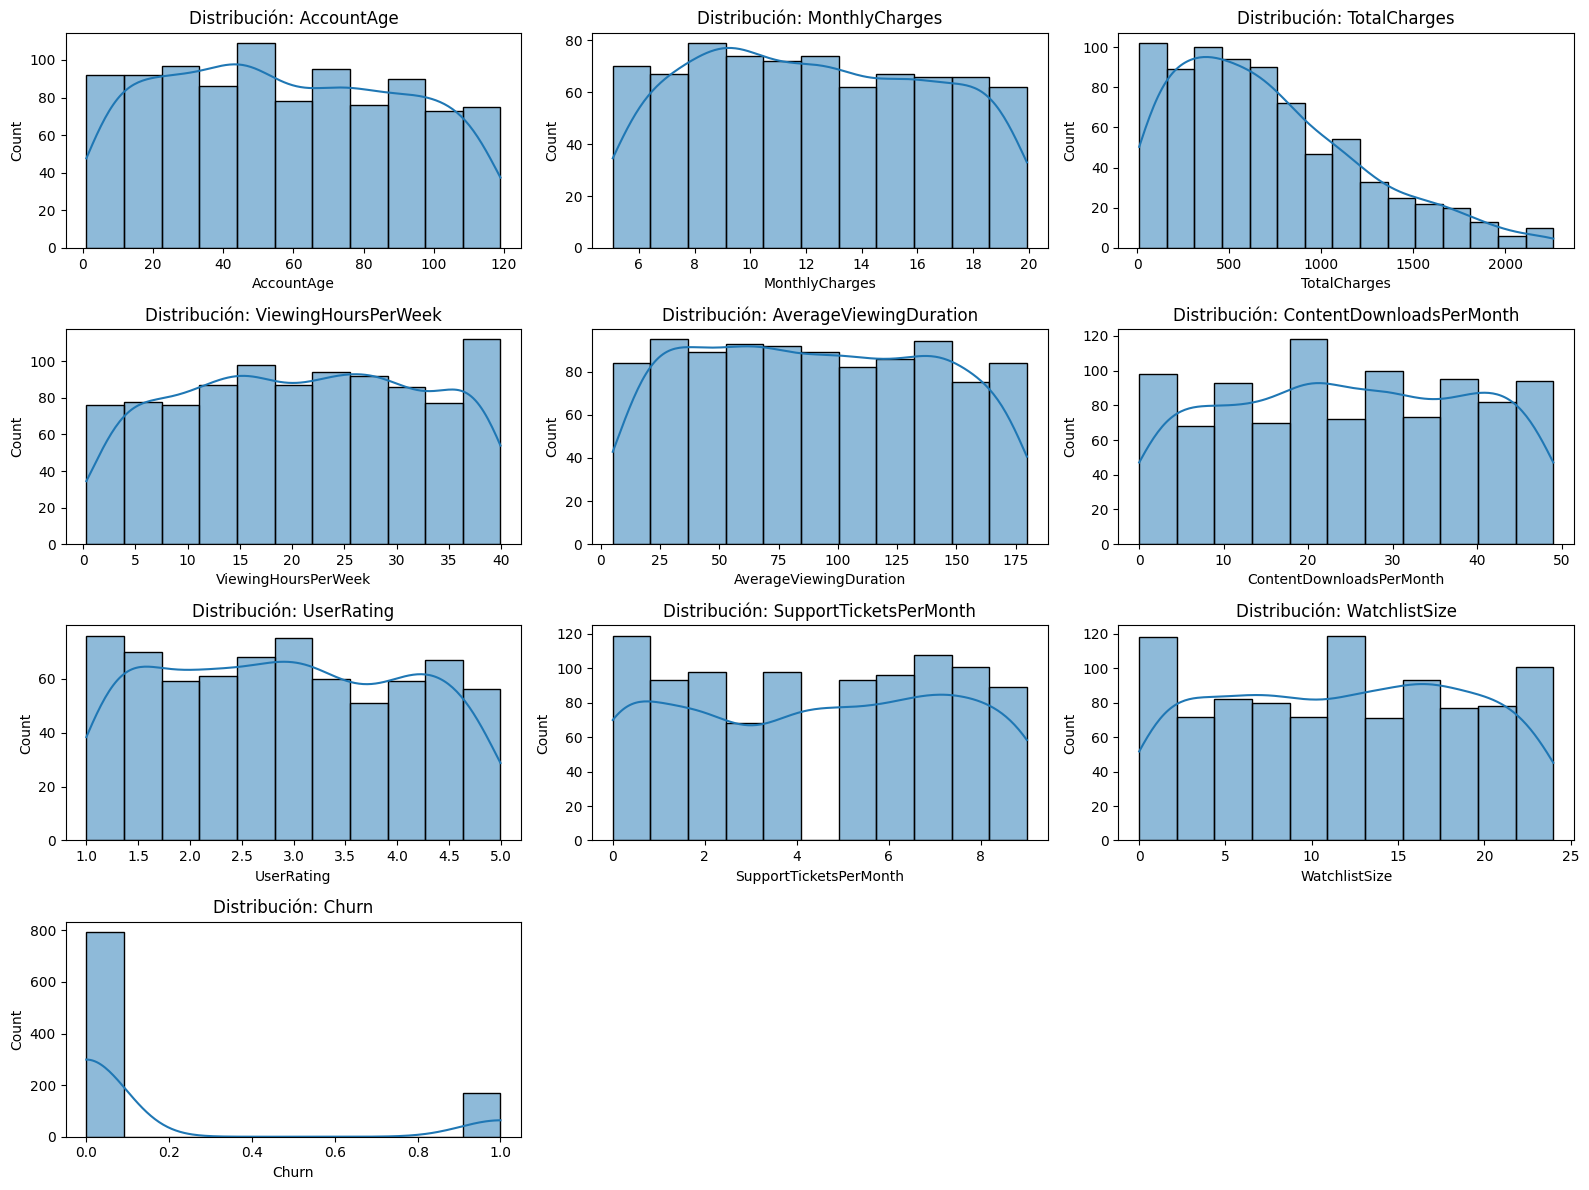

In [18]:
#Evaluación de la distribución de las variables numéricas
num_cols = df.select_dtypes(include=['int64','float64']).columns

plt.figure(figsize=(16, 12))

n = len(num_cols)
cols = 3
rows = math.ceil(n / cols)

for i, col in enumerate(num_cols, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribución: {col}")

plt.tight_layout()
plt.show()

**Comentario**: debemos arreglar la distribución de TotalCharges puesto que el modelo a utilizar para este fin será una Regresión Logística (por nuestra variable objetivo)

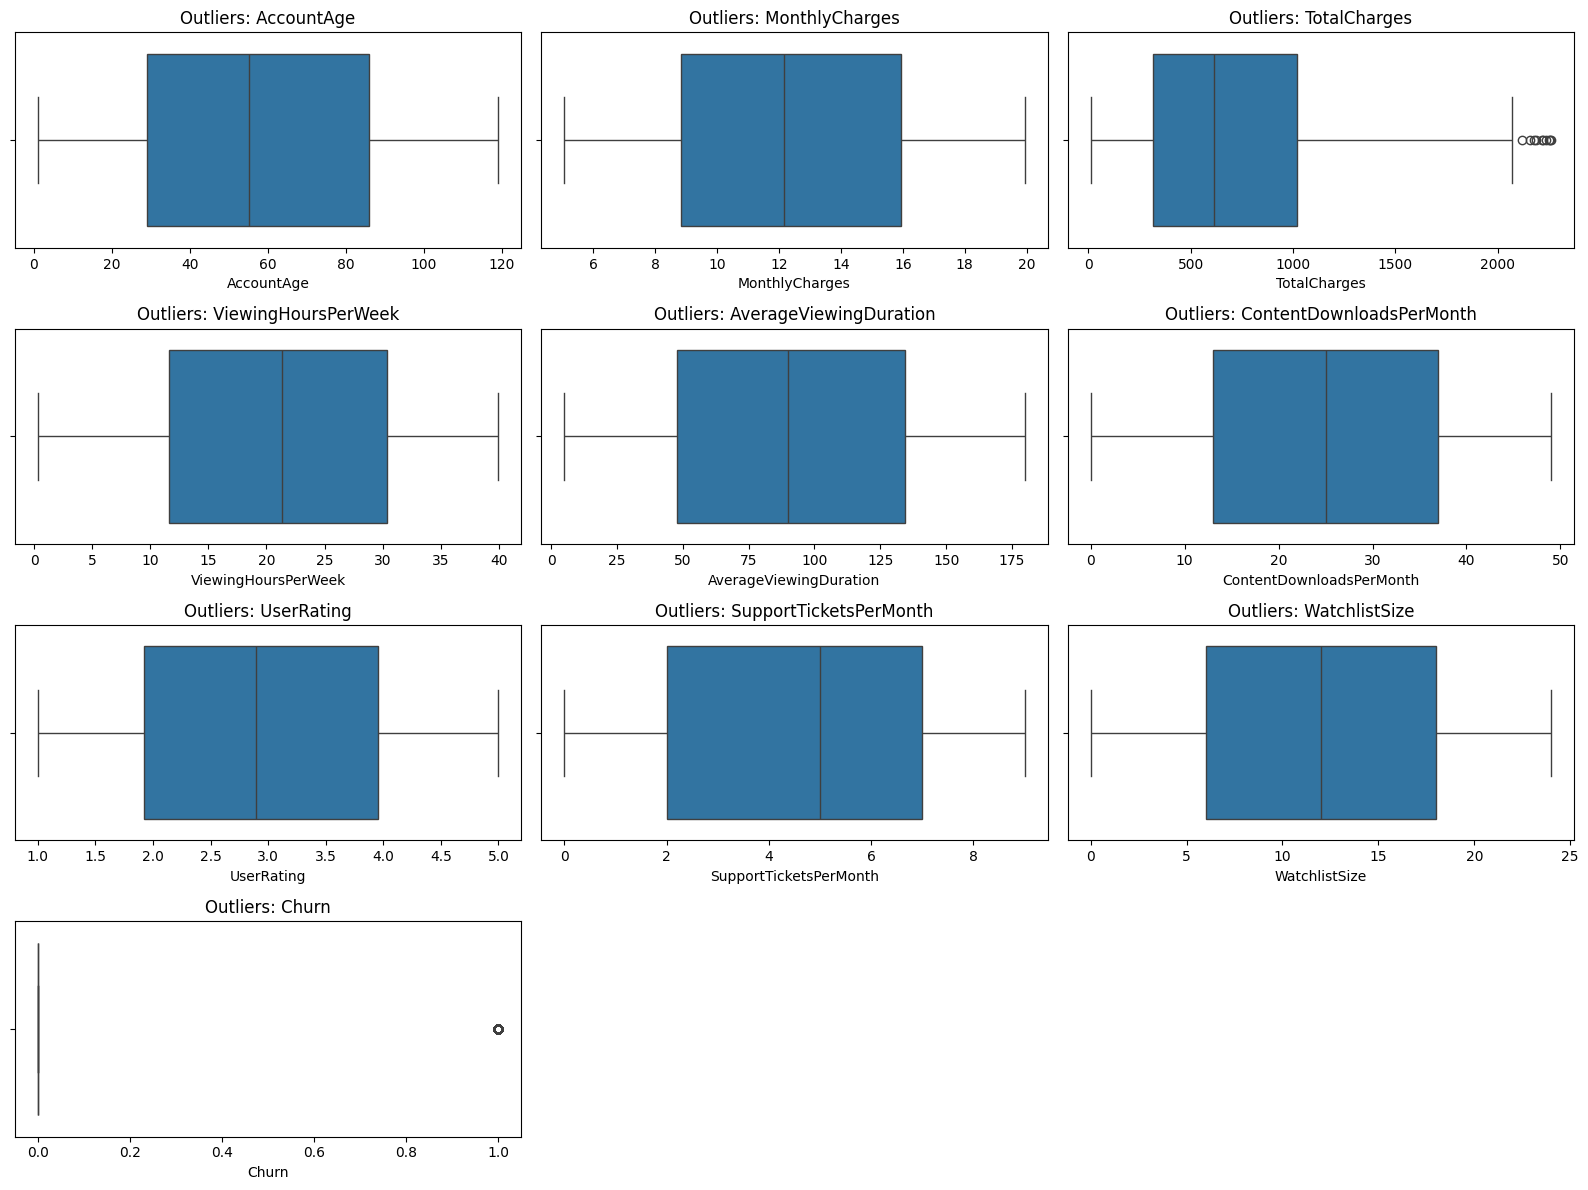

In [19]:
#Visualizaciones (BoxPlot) de variables numéricas para detectar outliers
plt.figure(figsize=(16, 12))

n = len(num_cols)
cols = 3
rows = math.ceil(n / cols)

for i, col in enumerate(num_cols, 1):
    plt.subplot(rows, cols, i)
    sns.boxplot(x=df[col])
    plt.title(f"Outliers: {col}")
plt.tight_layout()
plt.show()

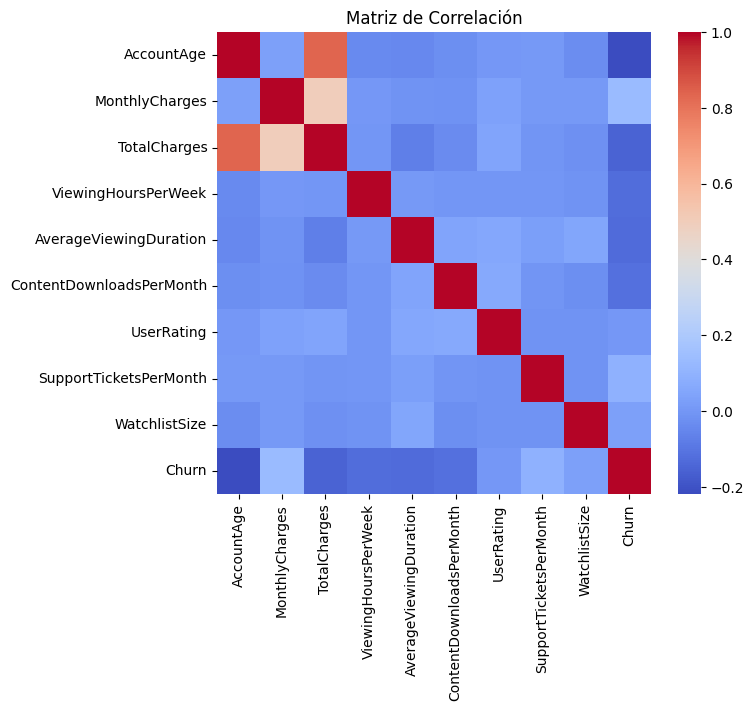

In [20]:
#Matriz de correlación entre variables numéricas
plt.figure(figsize=(7,6))
corr = df[num_cols].corr()
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title("Matriz de Correlación")
plt.show()

ValueError: num must be an integer with 1 <= num <= 9, not 10

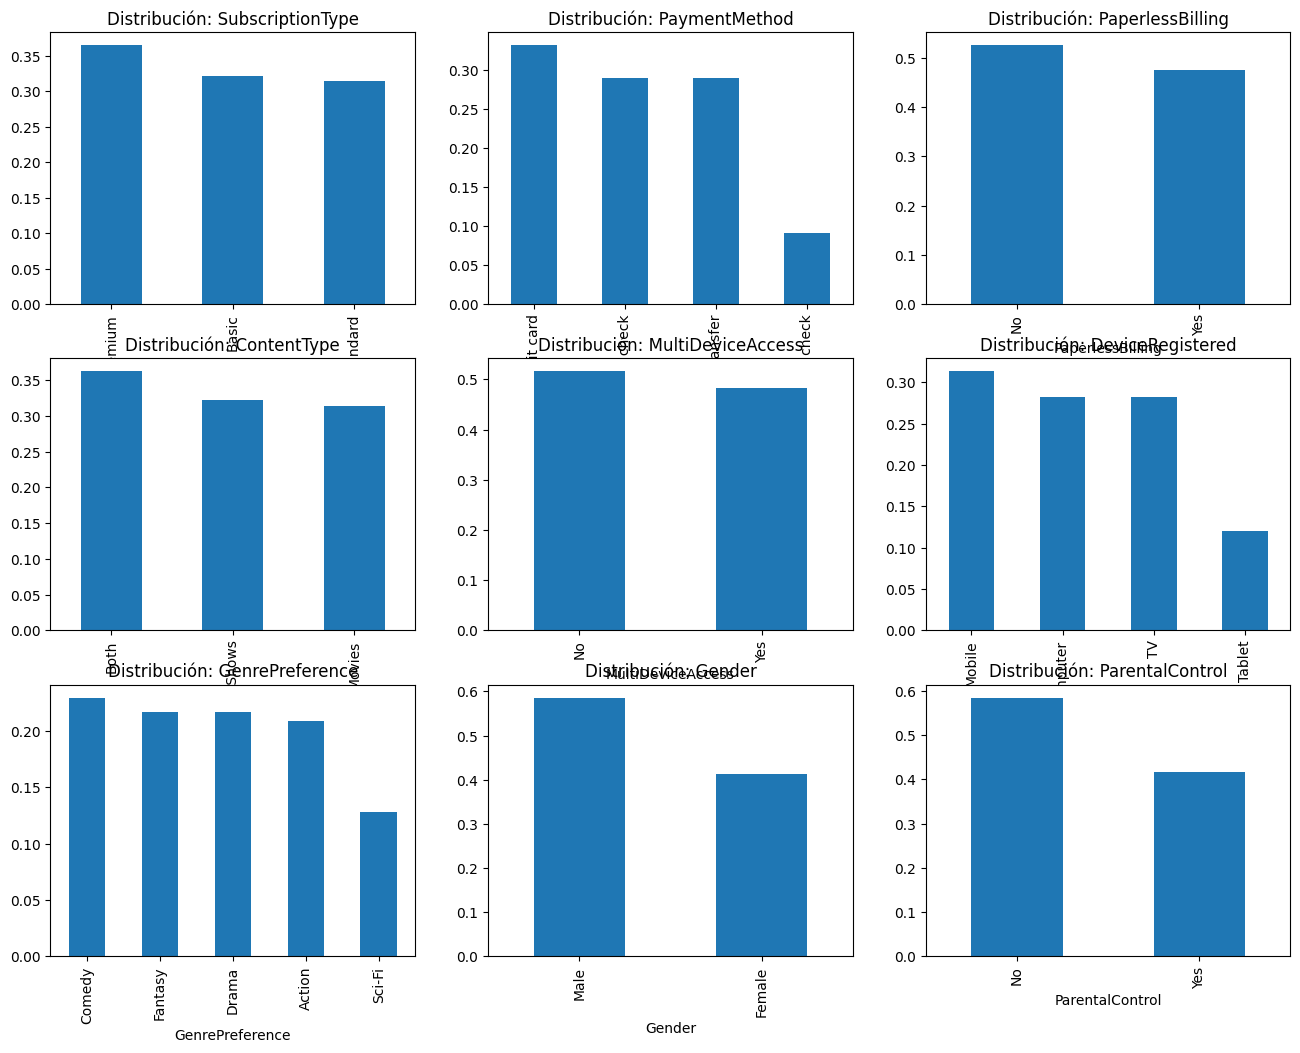

In [21]:
#Análisis de la distribución de las variables categóricas
cat_cols = df.select_dtypes(include='object').columns

plt.figure(figsize=(16,12))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(3, 3, i)
    df[col].value_counts(normalize=True).plot(kind='bar')
    plt.title(f"Distribución: {col}")
plt.tight_layout()
plt.show()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_18168\3159459919.py:10: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=col, hue='Churn', fill=True)


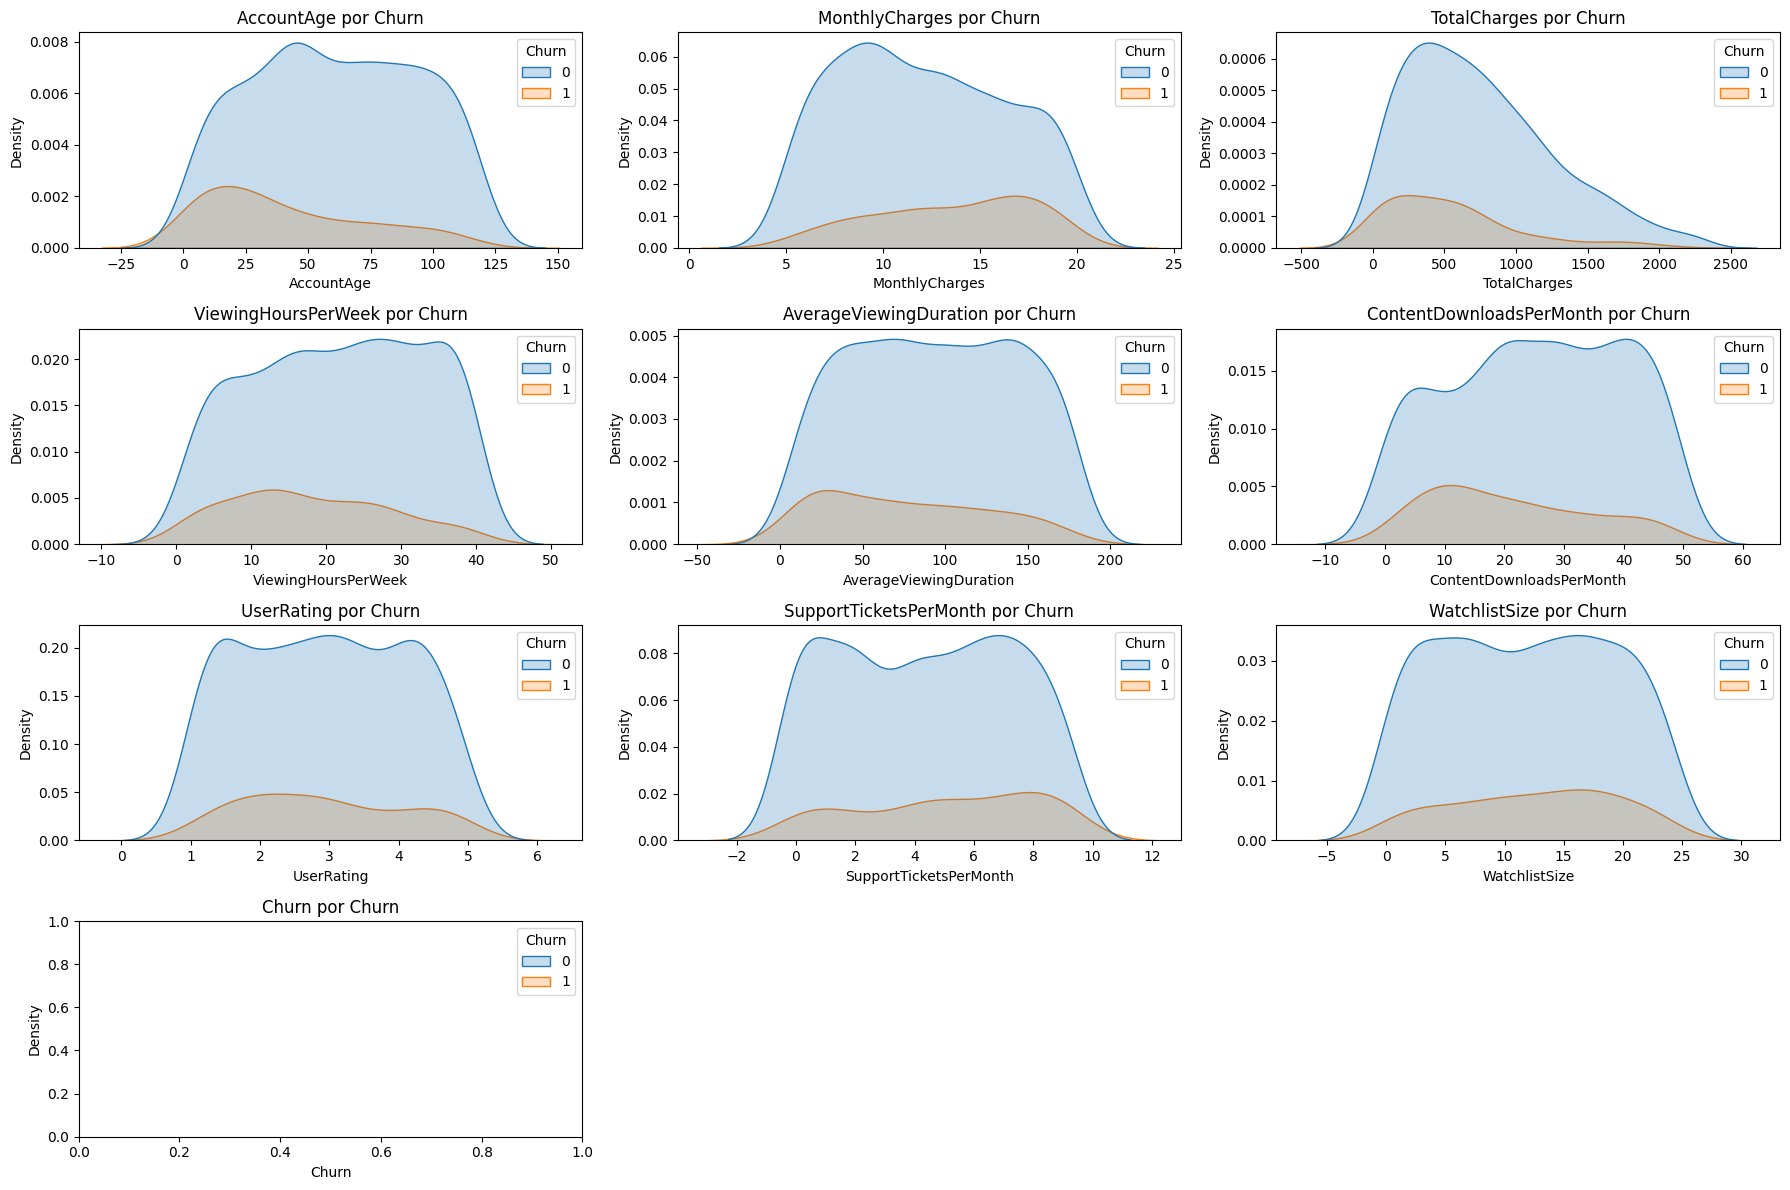

In [22]:
#Variables numéricas vs Churn
plt.figure(figsize=(18, 12))

n = len(num_cols)
cols = 3                      # cuántas gráficas por fila
rows = math.ceil(n / cols)    # calcula dinámicamente cuántas filas necesitas

for i, col in enumerate(num_cols, 1):
    plt.subplot(rows, cols, i)
    sns.kdeplot(data=df, x=col, hue='Churn', fill=True)
    plt.title(f"{col} por Churn")

plt.tight_layout()
plt.show()

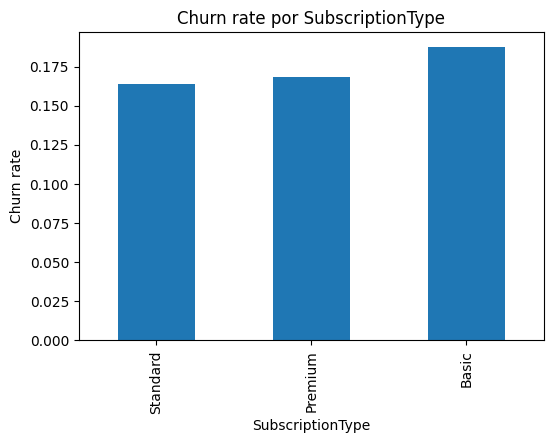

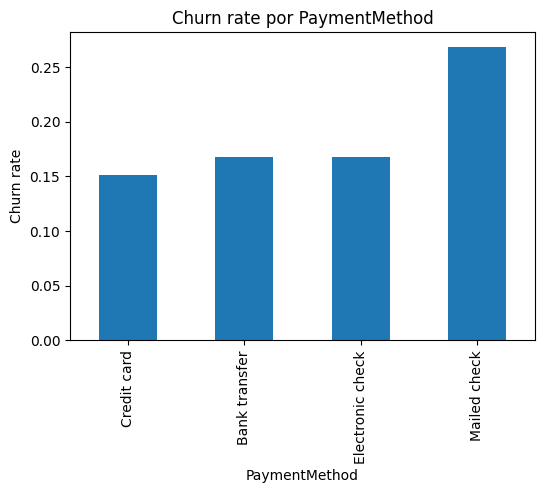

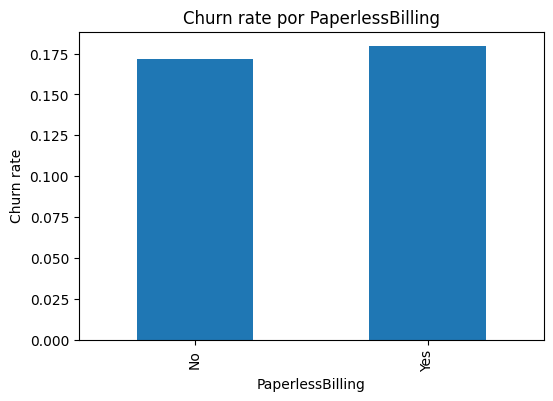

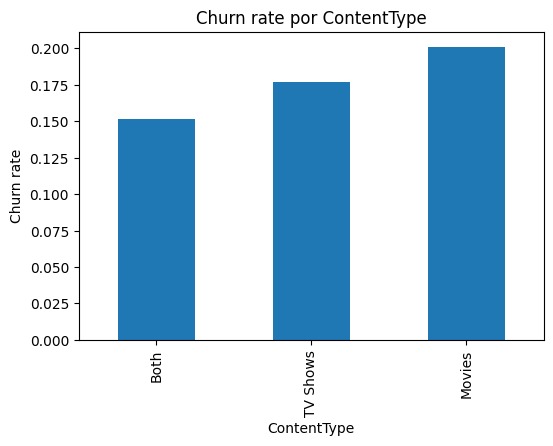

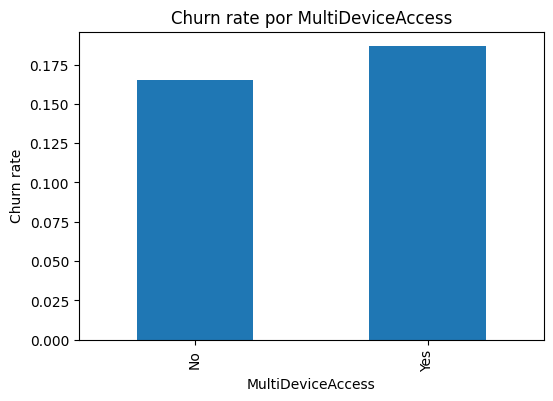

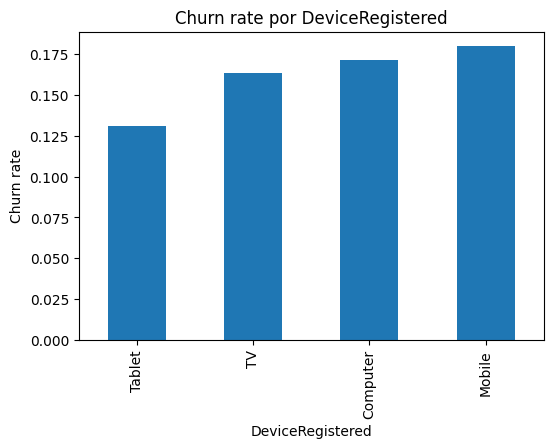

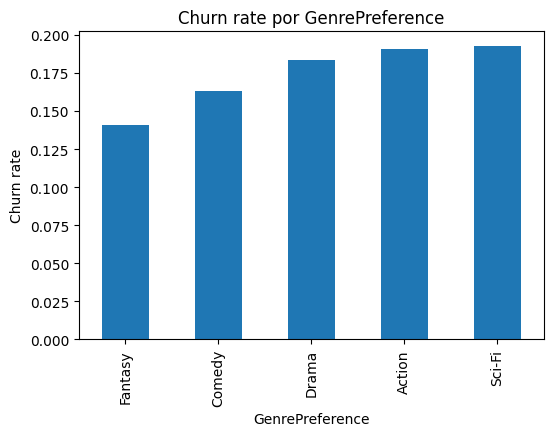

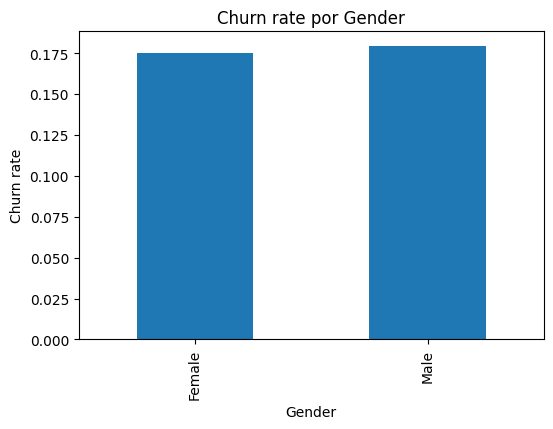

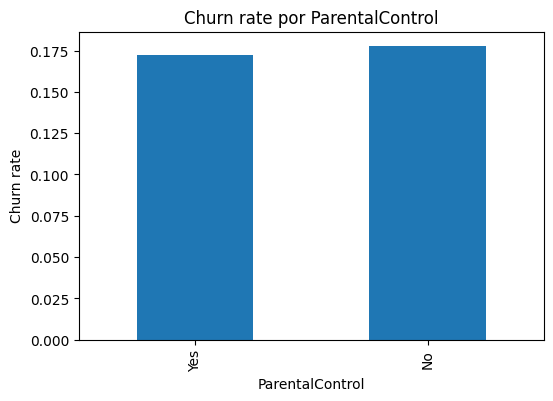

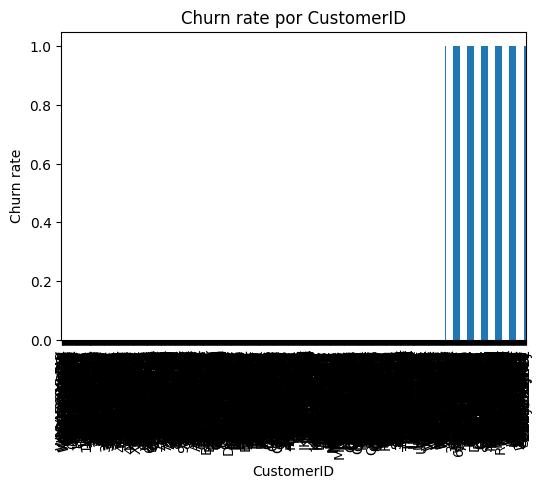

In [23]:
#Variables categóricas vs Churn
for col in cat_cols:
    plt.figure(figsize=(6,4))
    churn_rate = df.groupby(col)['Churn'].mean().sort_values()
    churn_rate.plot(kind='bar')
    plt.title(f"Churn rate por {col}")
    plt.ylabel("Churn rate")
    plt.show()

### 1.4 Imputación de variables con < 20% de faltantes 

In [24]:
df["SubscriptionType"].mode()

0    Premium
Name: SubscriptionType, dtype: object

##### Comentario: Imputamos estas variables porque sus faltantes no superan el 5%, podríamos imputar sin problema con la moda. La única variable mayoritariamente más desbalanceada es la de género, pero no tendrá ningún impacto significativo sobre el desbalance. 

In [25]:
# Imputación con moda
df["SubscriptionType"] = df["SubscriptionType"].fillna(df["SubscriptionType"].mode()[0])
df["DeviceRegistered"] = df["DeviceRegistered"].fillna(df["DeviceRegistered"].mode()[0])
df["Gender"] = df["Gender"].fillna(df["Gender"].mode()[0])

In [26]:
faltantes_2 = df.isna().mean()*100
faltantes_2[faltantes_2>0]

MonthlyCharges     21.183801
TotalCharges       19.314642
PaymentMethod      23.156802
GenrePreference    11.422638
UserRating         27.102804
dtype: float64

<Axes: >

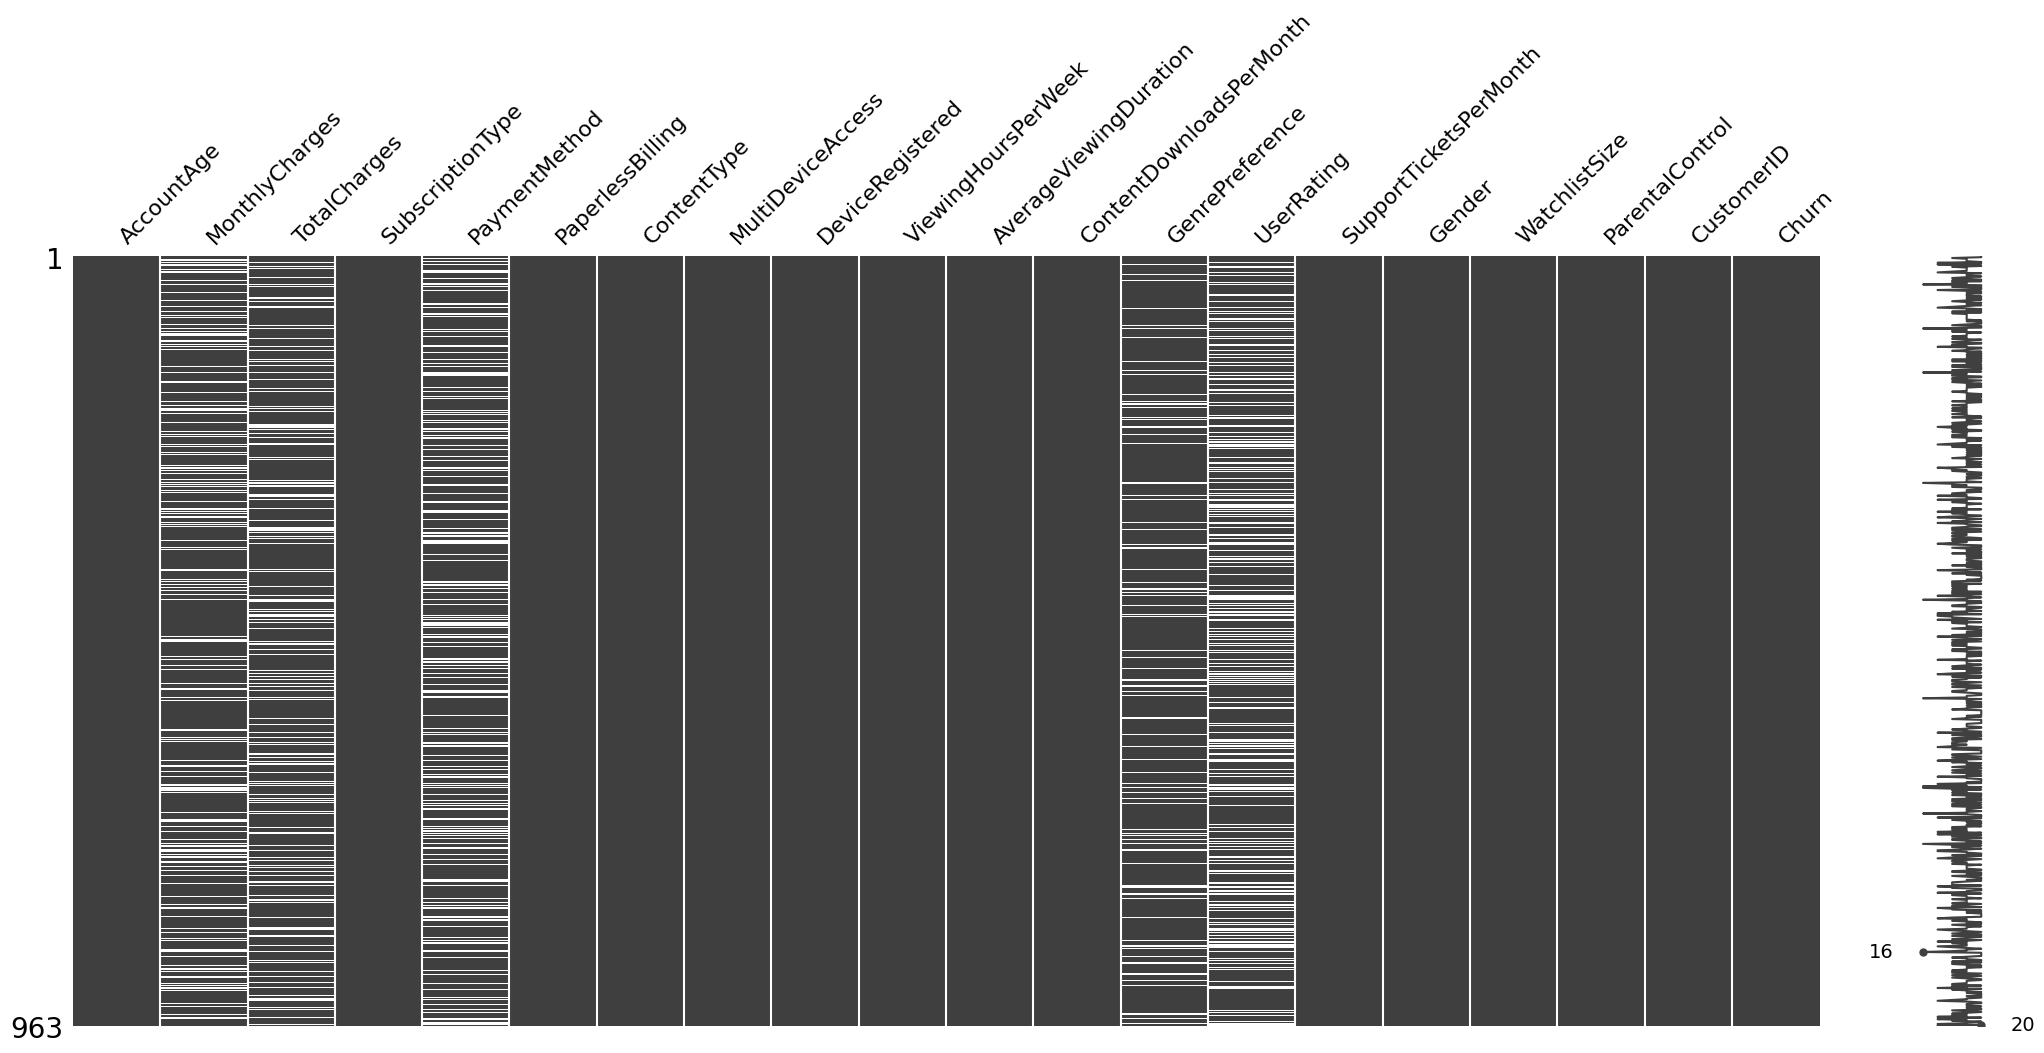

In [27]:
# Visualizamos los valores faltantes como una matriz
msno.matrix(df)

In [28]:
### Eliminaremos la columna de UserRating por la cantidad de faltantes
df.drop(columns=["UserRating"], axis=1, inplace=True)

In [29]:
#Faltantes de menos del 15% en la columna GenrePreference - imputamos por moda
df["GenrePreference"] = df["GenrePreference"].fillna(df["GenrePreference"].mode()[0])

In [30]:
#Revisiíon de los valores en la columna GenrePreference
df["GenrePreference"].value_counts() # ["Action","Drama","Comedy","Documental","Sci-Fi"

GenrePreference
Comedy     306
Fantasy    185
Drama      185
Action     178
Sci-Fi     109
Name: count, dtype: int64

In [31]:
#Imputacion por KNN los valores faltantes en las columnas numéricas (además ambas están muy relacionadas)
numerical_cols = ['MonthlyCharges', 'TotalCharges']
imputer_knn = KNNImputer(n_neighbors=5)
df[numerical_cols] = imputer_knn.fit_transform(df[numerical_cols])

In [32]:
#Confirmamos variaciones con describe antes y después de la imputación
df['MonthlyCharges'].describe()

count    963.000000
mean      12.317386
std        3.927830
min        5.062339
25%        9.287640
50%       12.287810
75%       15.330919
max       19.932542
Name: MonthlyCharges, dtype: float64

In [33]:
#Comprobamos valores de TotalCharges
df['TotalCharges'].describe()

count     963.000000
mean      715.122348
std       481.155303
min        11.582882
25%       348.815126
50%       649.842384
75%       994.499030
max      2261.019201
Name: TotalCharges, dtype: float64

In [34]:
#Guardamos para dashboards luego
df.to_csv(r'C:\Users\LENOVO\Documents\GitHub\ML_PowerBI\data\processed\df_BI1.csv', index=False)

In [35]:
df_BI = pd.read_csv(r'C:\Users\LENOVO\Documents\GitHub\ML_PowerBI\data\processed\df_BI1.csv')
df_BI.head()

,AccountAge,MonthlyCharges,TotalCharges,SubscriptionType,PaymentMethod,PaperlessBilling,ContentType,MultiDeviceAccess,DeviceRegistered,ViewingHoursPerWeek,AverageViewingDuration,ContentDownloadsPerMonth,GenrePreference,SupportTicketsPerMonth,Gender,WatchlistSize,ParentalControl,CustomerID,Churn
0,42,11.321950,475.521914,Basic,Electronic check,Yes,Movies,Yes,Tablet,0.386852,24.593361,25,Comedy,7,Female,15,No,LOHRYYC9E8,0
1,95,12.810915,1217.036887,Standard,Electronic check,Yes,TV Shows,No,Mobile,37.123000,102.860795,21,Comedy,3,Male,8,No,RIH7RFEZCS,0
2,6,10.400706,91.583304,Standard,Credit card,Yes,TV Shows,No,Tablet,30.716944,10.512415,29,Fantasy,4,Male,14,No,JB5J8X2UY1,1
3,54,17.917819,967.562224,Basic,NaN,Yes,Movies,No,Mobile,2.495373,45.246834,45,Drama,3,Male,12,No,Z4GZJIB90P,0
4,27,11.005068,339.057244,Basic,Mailed check,No,TV Shows,No,Mobile,39.936910,94.310954,44,Comedy,4,Female,18,No,B3BDJTW0L9,0


#### 1.5 Transformación logarítmica de TotalCharges

In [36]:
# Transformación logarítmica para reducir la asimetría en TotalCharges
df['TotalCharges_log'] = np.log1p(df['TotalCharges'])

In [37]:
#Eliminamos la columna original de TotalCharges
df.drop(columns=['TotalCharges'], axis=1, inplace=True)

In [38]:
#Guardamos el dataframe limpio en un nuevo archivo CSV
df.to_csv(r'C:\Users\LENOVO\Documents\GitHub\ML_PowerBI\data\processed\df_imp.csv', index=False)

In [ ]:
df.head()

,AccountAge,MonthlyCharges,SubscriptionType,PaymentMethod,PaperlessBilling,ContentType,MultiDeviceAccess,DeviceRegistered,ViewingHoursPerWeek,AverageViewingDuration,ContentDownloadsPerMonth,GenrePreference,SupportTicketsPerMonth,Gender,WatchlistSize,ParentalControl,CustomerID,Churn,TotalCharges_log
0,42,11.321950,Basic,Electronic check,Yes,Movies,Yes,Tablet,0.386852,24.593361,25,Comedy,7,Female,15,No,LOHRYYC9E8,0,6.166514
1,95,12.810915,Standard,Electronic check,Yes,TV Shows,No,Mobile,37.123000,102.860795,21,Comedy,3,Male,8,No,RIH7RFEZCS,0,7.104996
2,6,10.400706,Standard,Credit card,Yes,TV Shows,No,Tablet,30.716944,10.512415,29,Fantasy,4,Male,14,No,JB5J8X2UY1,1,4.528109
3,54,17.917819,Basic,NaN,Yes,Movies,No,Mobile,2.495373,45.246834,45,Drama,3,Male,12,No,Z4GZJIB90P,0,6.875813
4,27,11.005068,Basic,Mailed check,No,TV Shows,No,Mobile,39.936910,94.310954,44,Comedy,4,Female,18,No,B3BDJTW0L9,0,5.829114


In [39]:
df_BI.head(10)

,AccountAge,MonthlyCharges,TotalCharges,SubscriptionType,PaymentMethod,PaperlessBilling,ContentType,MultiDeviceAccess,DeviceRegistered,ViewingHoursPerWeek,AverageViewingDuration,ContentDownloadsPerMonth,GenrePreference,SupportTicketsPerMonth,Gender,WatchlistSize,ParentalControl,CustomerID,Churn
0,42,11.321950,475.521914,Basic,Electronic check,Yes,Movies,Yes,Tablet,0.386852,24.593361,25,Comedy,7,Female,15,No,LOHRYYC9E8,0
1,95,12.810915,1217.036887,Standard,Electronic check,Yes,TV Shows,No,Mobile,37.123000,102.860795,21,Comedy,3,Male,8,No,RIH7RFEZCS,0
2,6,10.400706,91.583304,Standard,Credit card,Yes,TV Shows,No,Tablet,30.716944,10.512415,29,Fantasy,4,Male,14,No,JB5J8X2UY1,1
3,54,17.917819,967.562224,Basic,NaN,Yes,Movies,No,Mobile,2.495373,45.246834,45,Drama,3,Male,12,No,Z4GZJIB90P,0
4,27,11.005068,339.057244,Basic,Mailed check,No,TV Shows,No,Mobile,39.936910,94.310954,44,Comedy,4,Female,18,No,B3BDJTW0L9,0
5,71,11.495290,818.287054,Premium,Credit card,No,Movies,Yes,Computer,7.310172,123.280794,30,Comedy,6,Female,16,Yes,5E4TQK5OVX,0
6,69,17.145910,1183.067820,Basic,NaN,No,Movies,Yes,Mobile,19.008900,86.122559,35,Sci-Fi,6,Female,5,No,8VFNZ1M1I9,1
7,76,17.461875,1327.102526,Premium,Electronic check,No,Movies,Yes,Mobile,24.429413,137.557874,32,Fantasy,9,Female,11,Yes,THKWUHOGUL,0
8,8,12.328262,714.052121,Premium,Electronic check,No,Both,Yes,Computer,15.488913,137.552942,16,Fantasy,3,Female,2,No,IGZ39O1ROC,0
9,26,19.699262,512.180802,Premium,Credit card,Yes,Both,Yes,Mobile,2.121762,164.073643,44,Drama,4,Male,16,Yes,JHTQYVGRR4,1
